In [1]:
!git clone https://github.com/grayfactory/Toxicity-Under-Context-Detect.git
%cd Toxicity-Under-Context-Detect/
!ls

Cloning into 'Toxicity-Under-Context-Detect'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 31 (delta 10), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (31/31), done.
Checking out files: 100% (14/14), done.
/content/Toxicity-Under-Context-Detect
data	   Preprocessing_data_and_prepare4training.ipynb  utils
model_ckp  README.md


In [2]:
!pip install transformers
!pip install datasets

from IPython.display import clear_output 

from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          AdamW, get_linear_schedule_with_warmup)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

from sklearn.model_selection import StratifiedShuffleSplit

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
from pathlib import Path
import random

from utils._utils import MyConfig, plot_confusion_matrix, plot_history
from utils.model import (tokenize_segmented_text, TOXICDataset, 
                         f1_score_model, AverageMeter, 
                         train_epoch, eval_model, model_score, EarlyStopping)


clear_output()

In [ ]:
# for model save
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# Set configs

In [3]:
configs = MyConfig({'path':{
    'path_drive' : Path('/content/gdrive/MyDrive/toxic_nlp'),
    'path_colab_data' : Path('./data')
    },
    'seeds' : 42,
    'model_to_use' : 'google/electra-small-discriminator',
    'tokenizer_to_use' : 'google/electra-small-discriminator',
    'model_ckp_dir' : Path('/content/gdrive/MyDrive/toxic_nlp/Electra-model-save')
})
configs.path['list_csv'] = [f for f in (configs.path['path_colab_data']).glob('*.csv')]

if configs.seeds:
  random.seed(configs.seeds)
  np.random.seed(configs.seeds)
  torch.manual_seed(configs.seeds)


# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
if torch.cuda.is_available():
  configs.device = "cuda"
else: configs.device="cpu"

print("Using {} device".format(configs.device))

configs

Using cuda device


{'device': 'cuda',
 'model_ckp_dir': PosixPath('/content/gdrive/MyDrive/toxic_nlp/Electra-model-save'),
 'model_to_use': 'google/electra-small-discriminator',
 'path': {'list_csv': [PosixPath('data/jig_test.csv'),
   PosixPath('data/combination-gan-ori.csv'),
   PosixPath('data/jig_all.csv'),
   PosixPath('data/combination-ori-gan.csv'),
   PosixPath('data/combination-gan-gan.csv'),
   PosixPath('data/combination-all-merged.csv'),
   PosixPath('data/combination-ori-ori.csv'),
   PosixPath('data/gc_clean.csv')],
  'path_colab_data': PosixPath('data'),
  'path_drive': PosixPath('/content/gdrive/MyDrive/toxic_nlp')},
 'seeds': 42,
 'tokenizer_to_use': 'google/electra-small-discriminator'}

In [28]:
if configs.model_ckp_dir.exists():
  configs.source = 'gdrive'
else : 
  configs.model_ckp_dir = Path('./model_ckp/')
  configs.source = 'github'


In [21]:
##
## train_condition setting
##
conditions = ['ori-ori','ori-gan','gan-ori','gan-gan','all-merged']
if configs.source == 'github':
  configs.train_condition = 'electra-generated-data-full-merged.pt'
else : 
  configs.train_condition = conditions[3]
print(configs.train_condition)

electra-generated-data-full-merged.pt


In [22]:
def get_data_csv_path(configs, condition):
  condition = condition
  return [f for f in configs.path['list_csv'] if f'{condition}' in str(f)][0]

In [ ]:
df_gan = pd.read_csv(get_data_csv_path(configs, configs.train_condition), index_col=0)
df_gan.label.value_counts()

1    12544
0    11130
Name: label, dtype: int64

In [ ]:
df_gan.shape

(23674, 3)

In [ ]:
from sklearn.model_selection import train_test_split
# split test data first
df_train = df_gan.copy()
train, test = train_test_split(df_train, test_size=0.15, random_state=configs.seeds)
print(f'train set shape : {train.shape}\ntest set shape : {test.shape}')
# train.head()

# split train & validation set
train = train.reset_index()
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=configs.seeds)

for train_idx, val_idx in split.split(train, train['label'] ):
    train, val = train.loc[train_idx], train.loc[val_idx]

# X, y 만 keep
X_train, y_train = train[['text','parent']], train['label']
X_val, y_val = val[['text','parent']], val['label']
X_test, y_test = test[['text','parent']], test['label']

print('\nratio of toxic / non toxic \n',y_train.value_counts() / len(y_train),'\n',
      y_val.value_counts() / len(y_val),
      '\n',y_test.value_counts() / len(y_test))
y_test.value_counts()

train set shape : (20122, 3)
test set shape : (3552, 3)

ratio of toxic / non toxic 
 1    0.529229
0    0.470771
Name: label, dtype: float64 
 1    0.529193
0    0.470807
Name: label, dtype: float64 
 1    0.533502
0    0.466498
Name: label, dtype: float64


1    1895
0    1657
Name: label, dtype: int64

In [ ]:
y_test.shape

(3552,)

In [ ]:
model_esc = ElectraForSequenceClassification.from_pretrained(configs.model_to_use).to(configs.device)
tokenizer = ElectraTokenizer.from_pretrained(configs.tokenizer_to_use)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

In [ ]:
configs.max_len = 256
configs.batch_size = 128
configs.EPOCHS = 10

configs.optimizer = AdamW(model_esc.parameters(), lr=1e-5)
configs.loss_fn = nn.CrossEntropyLoss().to(configs.device)

# model save path set
configs.model_save_dir = configs.path['path_drive'] / f'Electra-model-save/electra-{configs.train_condition}.pt'

configs.early_stop_patience = 4
configs.early_stop_delta = 0.01
# init early stopping
early_stopping = EarlyStopping(patience = configs.early_stop_patience, 
                               delta=configs.early_stop_delta,
                               verbose = True, 
                               path=configs.model_save_dir)

# load dataset
train_dataset = TOXICDataset(X_train, y_train, tokenizer, configs.max_len)
train_loader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=True)

val_dataset = TOXICDataset(X_val, y_val, tokenizer, configs.max_len)
val_loader = DataLoader(val_dataset, batch_size=configs.batch_size, shuffle=True)

configs.total_steps = len(train_loader) * configs.EPOCHS
configs.scheduler = get_linear_schedule_with_warmup(
                    configs.optimizer,
                    num_warmup_steps=0,
                    num_training_steps=configs.total_steps
                )


configs

{'EPOCHS': 10,
 'batch_size': 128,
 'device': 'cuda',
 'early_stop_delta': 0.01,
 'early_stop_patience': 4,
 'loss_fn': CrossEntropyLoss(),
 'max_len': 256,
 'model_ckp_dir': PosixPath('/content/gdrive/MyDrive/toxic_nlp/Electra-model-save'),
 'model_save_dir': PosixPath('/content/gdrive/MyDrive/toxic_nlp/Electra-model-save/electra-ori-ori.pt'),
 'model_to_use': 'google/electra-small-discriminator',
 'optimizer': AdamW (
 Parameter Group 0
     betas: (0.9, 0.999)
     correct_bias: True
     eps: 1e-06
     initial_lr: 1e-05
     lr: 1e-05
     weight_decay: 0.0
 ),
 'path': {'list_csv': [PosixPath('data/gc_clean.csv'),
   PosixPath('data/jig_all.csv'),
   PosixPath('data/combination-ori-ori.csv'),
   PosixPath('data/jig_test.csv'),
   PosixPath('data/combination-ori-gan.csv'),
   PosixPath('data/combination-gan-ori.csv'),
   PosixPath('data/combination-all-merged.csv'),
   PosixPath('data/combination-gan-gan.csv')],
  'path_colab_data': PosixPath('data'),
  'path_drive': PosixPath('/c

## Training Model


Validation loss decreased (inf --> 0.339411).  Saving model ...
Train Loss 0.53420 accuracy 0.83730 f1 0.85110
Val Loss 0.33941 accuracy 0.92621 f1 0.93165




Validation loss decreased (0.339411 --> 0.230409).  Saving model ...
Train Loss 0.28431 accuracy 0.93452 f1 0.93930
Val Loss 0.23041 accuracy 0.93764 f1 0.94271




Validation loss decreased (0.230409 --> 0.190503).  Saving model ...
Train Loss 0.20692 accuracy 0.94403 f1 0.94775
Val Loss 0.19050 accuracy 0.94460 f1 0.94860




EarlyStopping counter: 1 out of 4
Train Loss 0.17692 accuracy 0.94875 f1 0.95198
Val Loss 0.18113 accuracy 0.94460 f1 0.94872




Validation loss decreased (0.190503 --> 0.175074).  Saving model ...
Train Loss 0.16000 accuracy 0.95359 f1 0.95650
Val Loss 0.17507 accuracy 0.94460 f1 0.94861




EarlyStopping counter: 1 out of 4
Train Loss 0.14951 accuracy 0.95527 f1 0.95804
Val Loss 0.17178 accuracy 0.94534 f1 0.94927




EarlyStopping counter: 2 out of 4
Train Loss 0.14300 accuracy 0.95794 f1 0.96065
Val Loss 0.18149 accuracy 0.94311 f1 0.94688




EarlyStopping counter: 3 out of 4
Train Loss 0.13748 accuracy 0.96061 f1 0.96328
Val Loss 0.17633 accuracy 0.94683 f1 0.94979




EarlyStopping counter: 4 out of 4
Early stopping


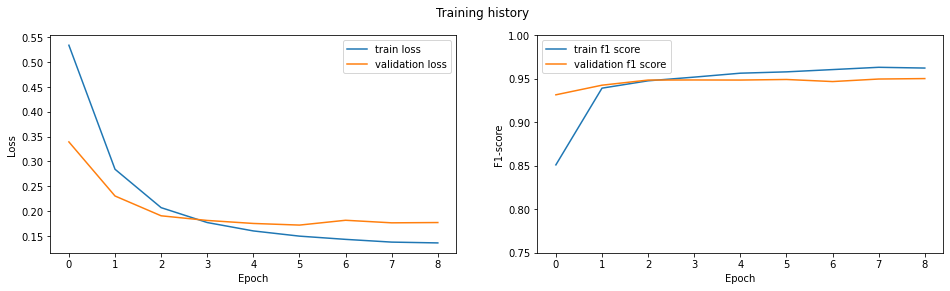

In [ ]:
from collections import defaultdict

history = defaultdict(list)

# lets training
for epoch in range(configs.EPOCHS):

  train_acc, train_loss, f1_train = train_epoch(
      model_esc,
      train_loader,
      configs.loss_fn,
      configs.optimizer,
      configs.device,
      configs.scheduler,
      len(train_dataset)
  )

  val_acc, val_loss, f1_val = eval_model(
      model_esc,
      val_loader,
      configs.loss_fn,
      configs.device,
      len(val_dataset)
  )

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['train_f1'].append(f1_train.avg.item())
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  history['val_f1'].append(f1_val.avg.item())

  early_stopping(val_loss, model_esc)

  if early_stopping.early_stop:
    print('Early stopping')
    break

  print(f'Train Loss {train_loss:.5f} accuracy {train_acc:.5f} f1 {f1_train.avg.item():.5f}')
  print(f'Val Loss {val_loss:.5f} accuracy {val_acc:.5f} f1 {f1_val.avg.item():.5f}')
  print()

plot_history(history)

## Evaluation with Test set

In [ ]:
# load test set without shuffle
test_dataset = TOXICDataset(X_test, y_test, tokenizer, configs.max_len)
test_loader = DataLoader(test_dataset, batch_size=configs.batch_size)
len(test_dataset)

7103

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score
from itertools import chain

y_pred, y_true, y_prob = model_score(model_esc, test_loader, configs)

predicted = list(chain.from_iterable(y_pred))
true_label = list(chain.from_iterable(y_true))
proba = list(chain.from_iterable(y_prob))

f1, roc_auc = f1_score(true_label, predicted), roc_auc_score(true_label, proba)

print(f'Electra train with - {configs.train_condition} - Condition\nResults f1 : {f1:.4f}, roc auc : {roc_auc:.4f}')




Electra train with - all-merged - Condition
Results f1 : 0.8956, roc auc : 0.9490


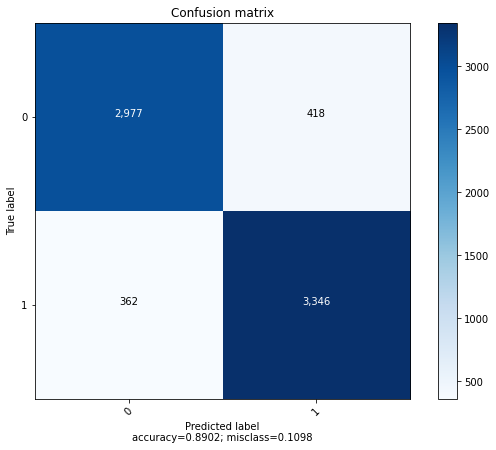

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_label, predicted)
target_name = [0,1]

plot_confusion_matrix(cm, target_name, normalize=False)

## Benchmark (or) Generalization Test. with Kaggle Toxic Dataset
- context가 있는 Toxic detaction benchmark dataset은 존재하지 않기 때문에, kaggle toxic data에서 성능을 평가해보자.
- kaggle toxic data는 context가 없다.

In [ ]:
configs

{'EPOCHS': 10,
 'batch_size': 128,
 'device': 'cuda',
 'early_stop_delta': 0.01,
 'early_stop_patience': 4,
 'loss_fn': CrossEntropyLoss(),
 'max_len': 256,
 'model_ckp_dir': PosixPath('/content/gdrive/MyDrive/toxic_nlp/Electra-model-save'),
 'model_save_dir': PosixPath('/content/gdrive/MyDrive/toxic_nlp/Electra-model-save/electra-all-merged.pt'),
 'model_to_use': 'google/electra-small-discriminator',
 'optimizer': AdamW (
 Parameter Group 0
     betas: (0.9, 0.999)
     correct_bias: True
     eps: 1e-06
     initial_lr: 1e-05
     lr: 1e-05
     weight_decay: 0.0
 ),
 'path': {'list_csv': [PosixPath('data/jig_all.csv'),
   PosixPath('data/combination-gan-ori.csv'),
   PosixPath('data/combination-ori-ori.csv'),
   PosixPath('data/combination-all-merged.csv'),
   PosixPath('data/combination-ori-gan.csv'),
   PosixPath('data/jig_test.csv'),
   PosixPath('data/combination-gan-gan.csv'),
   PosixPath('data/gc_clean.csv')],
  'path_colab_data': PosixPath('data'),
  'path_drive': PosixPath(

In [ ]:
df_jig = pd.read_csv(get_data_csv_path(configs, 'jig_all.csv'), index_col=0)
df_jig

,comment_text,parent,toxic
0,Thank you for understanding. I think very high...,NaN,0
1,:Dear god this site is horrible.,NaN,0
2,"""::: Somebody will invariably try to add Relig...",NaN,0
3,""" \n\n It says it right there that it IS a typ...",NaN,0
4,""" \n\n == Before adding a new product to the l...",NaN,0
...,...,...,...
127951,":Jerome, I see you never got around to this…! ...",NaN,0
127952,==Lucky bastard== \n http://wikimediafoundatio...,NaN,0
127953,==shame on you all!!!== \n\n You want to speak...,NaN,0
127954,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,NaN,1


In [ ]:
df_jig.toxic.value_counts()

0    115776
1     12180
Name: toxic, dtype: int64

In [ ]:
X_test = df_jig[['comment_text','parent']]
y_test = df_jig['toxic']
configs.model_save_dir

PosixPath('/content/gdrive/MyDrive/toxic_nlp/Electra-model-save/electra-all-merged.pt')

In [14]:
configs

{'device': 'cuda',
 'model_ckp_dir': PosixPath('Toxicity-Under-Context-Detect/model_ckp'),
 'model_to_use': 'google/electra-small-discriminator',
 'path': {'list_csv': [PosixPath('data/jig_test.csv'),
   PosixPath('data/combination-gan-ori.csv'),
   PosixPath('data/jig_all.csv'),
   PosixPath('data/combination-ori-gan.csv'),
   PosixPath('data/combination-gan-gan.csv'),
   PosixPath('data/combination-all-merged.csv'),
   PosixPath('data/combination-ori-ori.csv'),
   PosixPath('data/gc_clean.csv')],
  'path_colab_data': PosixPath('data'),
  'path_drive': PosixPath('/content/gdrive/MyDrive/toxic_nlp')},
 'seeds': 42,
 'source': 'github',
 'tokenizer_to_use': 'google/electra-small-discriminator',
 'train_condition': 'ori-ori'}

In [37]:
# incase evaluation with uploaded model
if configs.source == 'github':
  configs.model_save_dir = configs.model_ckp_dir / 'electra-generated-data-full-merged.pt'


?


In [39]:
# fine-tuning model with condition!
model_generated = ElectraForSequenceClassification.from_pretrained(configs.model_to_use).to(configs.device)
model_generated.load_state_dict(torch.load(configs.model_save_dir))

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

<All keys matched successfully>

In [ ]:
# load test set without shuffle
test_dataset = TOXICDataset(X_test, y_test, tokenizer, configs.max_len)
test_loader = DataLoader(test_dataset, batch_size=configs.batch_size)
len(test_dataset)

127956

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from itertools import chain

y_pred, y_true, y_prob = model_score(model_generated, test_loader, configs)

predicted = list(chain.from_iterable(y_pred))
true_label = list(chain.from_iterable(y_true))
proba = list(chain.from_iterable(y_prob))

f1, roc_auc = f1_score(true_label, predicted), roc_auc_score(true_label, proba)

print(f'Electra train with - {configs.train_condition} - Condition\nResults f1 : {f1:.4f}, roc auc : {roc_auc:.4f}')


cm = confusion_matrix(true_label, predicted)
target_name = [0,1]

plot_confusion_matrix(cm, target_name, normalize=False)

NameError: ignored

Electra train with - all-merged - Condition
Results f1 : 0.4886, roc auc : 0.9020


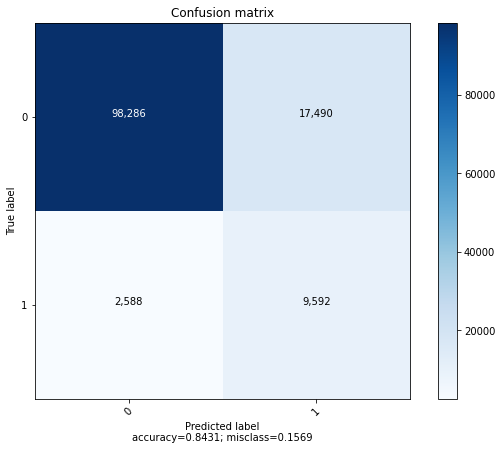

In [ ]:
from itertools import chain

predicted = list(chain.from_iterable(y_pred))
true_label = list(chain.from_iterable(y_true))
proba = list(chain.from_iterable(y_prob))

f1, roc_auc = f1_score(true_label, predicted), roc_auc_score(true_label, proba)

print(f'Electra train with - {configs.train_condition} - Condition\nResults f1 : {f1:.4f}, roc auc : {roc_auc:.4f}')


cm = confusion_matrix(true_label, predicted)
target_name = [0,1]

plot_confusion_matrix(cm, target_name, normalize=False)